In [6]:
## Authors: Marco Souza de Joode, Jan Straub

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def advect_conservative_donorcell(xi,rho,ui,dt):
    rhonew             = np.zeros_like(rho)
    N = len(rho)
    rhonew[0]          = rho[N-2]
    rhonew[-1]         = rho[1]
    F                  = np.zeros(len(ui))
    mask               = ui[1:-1]>0
    F[1:-1][mask]      = rho[:-1][mask] * ui[1:-1][mask]
    mask               = ui[1:-1]<0
    F[1:-1][mask]      = rho[1:][mask]  * ui[1:-1][mask]
    rhonew[1:-1]       = rho[1:-1] - dt * ( F[2:-1] - F[1:-2] ) / ( xi[2:-1] - xi[1:-2] )
    return rhonew

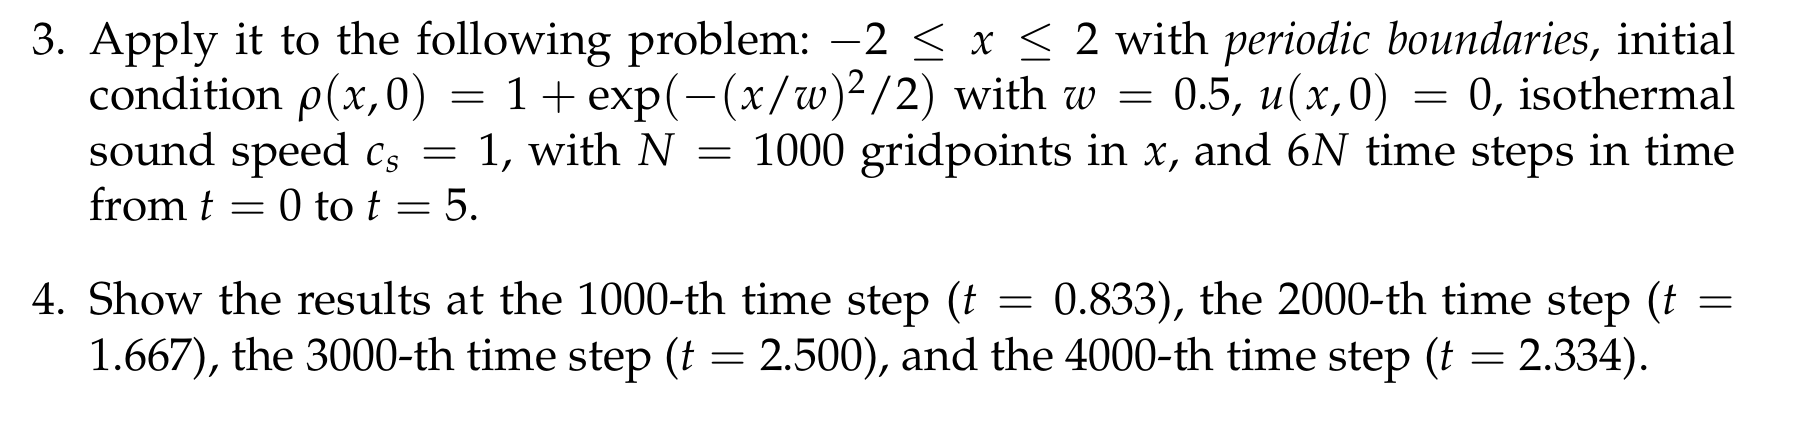

# TEST OF SIMPLE ADVECTION W PER. BC

Advecting a little box of gas around a cylinder. It diffuses after a while

(101,) (101,) (100,)


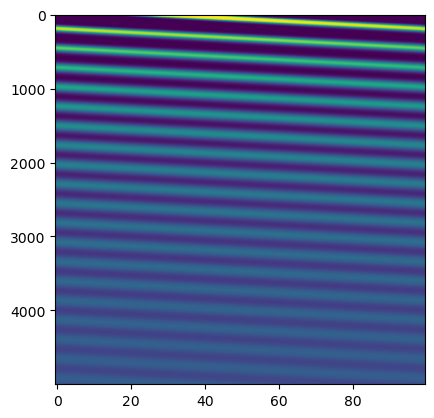

In [3]:
xi = np.linspace(0, 4, 101)
ui = np.ones((101))
xc = np.linspace(0, 4, 100)


def init2_rho(x):
    rho = np.zeros(x.shape)
    mask1 = 0.5 <= x
    mask2 = x <= 1.5
    mask = mask1 * mask2
    rho[mask] = 1.0
    return rho

rho = init2_rho(xc)

print(ui.shape, xi.shape, rho.shape)
dt = 3.0 / 200.0

T = 5000
rhomat = np.zeros((T, 100))
for n in range(T):
    rhomat[n, :] = rho
    rho = advect_conservative_donorcell(xi, rho, ui, dt)
plt.imshow(rhomat, aspect=0.02)
plt.show()

In [4]:
N = 1000
w = 0.5
xi = np.linspace(-2, 2, N+1)
xc = np.linspace(-2, 2, N)

ts = np.linspace(0, 5, 6*N)

rhos = np.zeros((6*N, N))
ui = np.zeros((6*N, N+1))

dt = ts[1] - ts[0]
sound_speed = 1
rho_0 = 1.0 + np.exp(-(xc/w)**2 / 2)
u_0 = 0.0 * xi
u_test = u_0 + 1.0

In [5]:
def rhs_p(p, xi):

    dx = xi[1] - xi[0]
    
    rhs = np.zeros(p.shape)
    for i in range(N):
        rhs[i] = -(p[(i+1) % N] - p[(i-1) % N]) / (2*dx)

    # as the rho is symmetric over the edges,
    # the symmetric derivative vanishes -- i think!
    return rhs

In [10]:
def timestep(q0, q1, xi,ui, dt):
    #inforce boundary
    q0_tilde = advect_conservative_donorcell(xi, q0, ui, dt)
    q1_tilde = advect_conservative_donorcell(xi, q1, ui, dt)

    q0_tilde[0] = q0_tilde[N-2]
    q0_tilde[N-1] = q0_tilde[1]

    q1_tilde[0] = q1_tilde[N-2]
    q1_tilde[N-1] = q1_tilde[1]

    #plt.title("q0 Tilde")
    #plt.plot(q0_tilde[:15])
    #plt.plot(q0_tilde[-15:])
    #plt.show()
    
    #inforce boundary
    p = q0_tilde * sound_speed**2
    RHS = rhs_p(p, xi)

    #plt.plot(RHS[:])
    #plt.show()
    
    q0 = q0_tilde
    q1 = q1_tilde + dt * RHS

    q0[0] = q0[-2]
    q0[-1] = q0[1]
    q1[0] = q1[-2]
    q1[-1] = q1[1]

    #plt.title("q1")
    #plt.plot(q1[:15])
    #plt.plot(q1[-15:])
    #plt.show()

    return q0, q1

In [22]:
q0 = rho_0
ui = np.zeros((N + 1))
u = np.zeros((N))


q1 = rho_0 * 0.0

dtt = 5.0 / (6*N)

q0s = np.zeros((6*N, N))
q1s = np.zeros((6*N, N))
us = np.zeros((6*N, N))

for n in range(6*N):
    q0, q1 = timestep(q0, q1, xi,ui,dtt)
    u = q1 / q0
    ui[1:-1] = 0.5*(u[:-1] + u[1:])
    
    ui[0] = 0.5 * (u[0] + u[1])
    ui[N] = 0.5 * (u[0] + u[1])

    us[n, :] = u
    q0s[n, :] = q0
    q1s[n, :] = q1

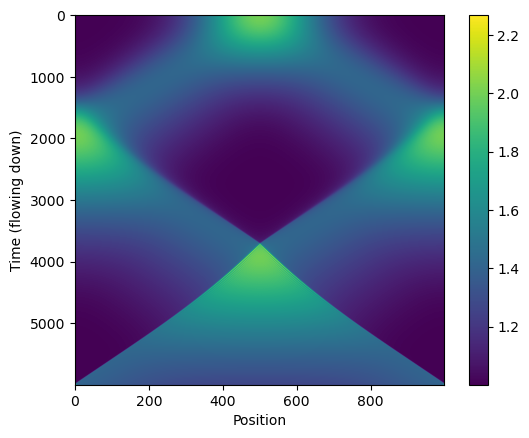

In [26]:
plt.imshow(q0s, aspect = 1.0/6.0)
plt.ylabel("Time (flowing down)")
plt.xlabel("Position")
plt.colorbar()

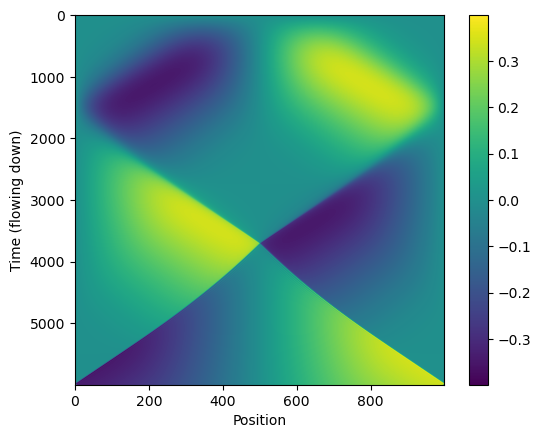

In [27]:
plt.imshow(us, aspect = 1.0/6.0)
plt.ylabel("Time (flowing down)")
plt.xlabel("Position")
plt.colorbar()

In [53]:

imax = 200
for n in range(0, 6*N, 10):
    plt.title(f"Time = {dtt * n :.3f}")
    plt.plot(xi[:-1], q0s[n], c="k", linewidth=2)

    if (n > imax):
        for i in range(imax):
            plt.plot(xi[:-1], q0s[n-i], c="r",alpha= np.max([0, (0.7 -np.exp((-imax + i)/200))]),  linewidth=0.3)

    plt.ylim(0.9, 2.3)
    plt.savefig(f"anim/frame_{n//10:07d}.png", dpi=200)
    plt.clf()

<Figure size 640x480 with 0 Axes>

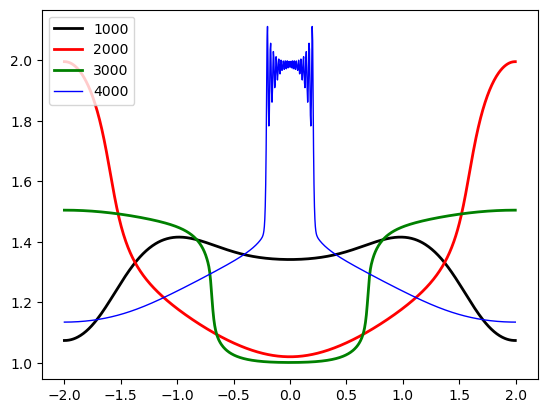

In [59]:
plt.plot(xi[:-1], q0s[1000], c="k",label="1000", linewidth=2)
plt.plot(xi[:-1], q0s[2000], c="r",label="2000", linewidth=2)
plt.plot(xi[:-1], q0s[3000], c="g",label="3000", linewidth=2)
plt.plot(xi[:-1], q0s[4000], c="b",label="4000", linewidth=1)
plt.legend(loc=)
plt.show()